<a href="https://colab.research.google.com/github/tomohitom/Tennis_Game_Analysis/blob/master/Openpose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone "https://github.com/YutaroOgawa/pytorch_advanced.git"

Cloning into 'pytorch_advanced'...
remote: Enumerating objects: 529, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 529 (delta 23), reused 32 (delta 13), pack-reused 479
Receiving objects: 100% (529/529), 17.57 MiB | 11.34 MiB/s, done.
Resolving deltas: 100% (282/282), done.


In [2]:
import os
import urllib.request
import zipfile
import tarfile

data_dir = "/content/pytorch_advanced/4_pose_estimation/data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

weights_dir = "/content/pytorch_advanced/4_pose_estimation/weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

url =  "http://images.cocodataset.org/zips/val2014.zip"
target_path = os.path.join(data_dir, "val2014.zip") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    zip = zipfile.ZipFile(target_path)
    zip.extractall(data_dir)  # ZIPを解凍
    zip.close()  # ZIPファイルをクローズ

COCO.jsonとmask.tar.gzを「data」ディレクトリにアップロード

In [3]:
save_path = os.path.join("/content/pytorch_advanced/4_pose_estimation/data", "mask.tar.gz") 

with tarfile.open(save_path, 'r:*') as tar:
    tar.extractall("/content/pytorch_advanced/4_pose_estimation/data")

画像の前処理作成

In [31]:
import cv2
import numpy as np
import random
import json

import torch
from torchvision import transforms


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, meta_data, img, mask_miss):
        for t in self.transforms:
            meta_data, img, mask_miss = t(meta_data, img, mask_miss)

        return meta_data, img, mask_miss


class get_anno(object):
    def __call__(self, meta_data, img, mask_miss):
        anno = dict()
        anno['dataset'] = meta_data['dataset']
        anno['img_height'] = int(meta_data['img_height'])
        anno['img_width'] = int(meta_data['img_width'])

        anno['isValidation'] = meta_data['isValidation']
        anno['people_index'] = int(meta_data['people_index'])
        anno['annolist_index'] = int(meta_data['annolist_index'])

        # (b) objpos_x (float), objpos_y (float)
        anno['objpos'] = np.array(meta_data['objpos'])
        anno['scale_provided'] = meta_data['scale_provided']
        anno['joint_self'] = np.array(meta_data['joint_self'])

        anno['numOtherPeople'] = int(meta_data['numOtherPeople'])
        anno['num_keypoints_other'] = np.array(
            meta_data['num_keypoints_other'])
        anno['joint_others'] = np.array(meta_data['joint_others'])
        anno['objpos_other'] = np.array(meta_data['objpos_other'])
        anno['scale_provided_other'] = meta_data['scale_provided_other']
        anno['bbox_other'] = meta_data['bbox_other']
        anno['segment_area_other'] = meta_data['segment_area_other']

        if anno['numOtherPeople'] == 1:
            anno['joint_others'] = np.expand_dims(anno['joint_others'], 0)
            anno['objpos_other'] = np.expand_dims(anno['objpos_other'], 0)

        meta_data = anno

        return meta_data, img, mask_miss


class add_neck(object):
    '''
    アノテーションデータの順番を変更し、さらに首のアノテーションデータを追加します。
    首ポジションは両肩の位置から計算します。

    MS COCO annotation order:
    0: nose	   		1: l eye		2: r eye	3: l ear	4: r ear
    5: l shoulder	6: r shoulder	7: l elbow	8: r elbow
    9: l wrist		10: r wrist		11: l hip	12: r hip	13: l knee
    14: r knee		15: l ankle		16: r ankle
    The order in this work:
    (0-'nose'	1-'neck' 2-'right_shoulder' 3-'right_elbow' 4-'right_wrist'
    5-'left_shoulder' 6-'left_elbow'	    7-'left_wrist'  8-'right_hip'
    9-'right_knee'	 10-'right_ankle'	11-'left_hip'   12-'left_knee'
    13-'left_ankle'	 14-'right_eye'	    15-'left_eye'   16-'right_ear'
    17-'left_ear' )
    '''

    def __call__(self, meta_data, img, mask_miss):
        meta = meta_data
        our_order = [0, 17, 6, 8, 10, 5, 7, 9,
                     12, 14, 16, 11, 13, 15, 2, 1, 4, 3]
        # Index 6 is right shoulder and Index 5 is left shoulder
        right_shoulder = meta['joint_self'][6, :]
        left_shoulder = meta['joint_self'][5, :]
        neck = (right_shoulder + left_shoulder) / 2

        # right_shoulder[2]が値1のときはアノテーションがあり画像内に部位も見えている
        # 値0のときはアノテーションの座標情報はあるが、画像内に部位は映っていない
        # 値が2のときは画像内に写っておらず、アノテーション付けもない
        # ※注意　元のMSCOCOの定義と値の意味が変わっている
        # v=0: not labeled (in which case x=y=0), v=1: labeled but not visible, and v=2: labeled and visible.
        if right_shoulder[2] == 2 or left_shoulder[2] == 2:
            neck[2] = 2
        elif right_shoulder[2] == 1 or left_shoulder[2] == 1:
            neck[2] = 1
        else:
            neck[2] = right_shoulder[2] * left_shoulder[2]

        neck = neck.reshape(1, len(neck))
        neck = np.round(neck)
        meta['joint_self'] = np.vstack((meta['joint_self'], neck))
        meta['joint_self'] = meta['joint_self'][our_order, :]
        temp = []

        for i in range(meta['numOtherPeople']):
            right_shoulder = meta['joint_others'][i, 6, :]
            left_shoulder = meta['joint_others'][i, 5, :]
            neck = (right_shoulder + left_shoulder) / 2
            if (right_shoulder[2] == 2 or left_shoulder[2] == 2):
                neck[2] = 2
            elif (right_shoulder[2] == 1 or left_shoulder[2] == 1):
                neck[2] = 1
            else:
                neck[2] = right_shoulder[2] * left_shoulder[2]
            neck = neck.reshape(1, len(neck))
            neck = np.round(neck)
            single_p = np.vstack((meta['joint_others'][i], neck))
            single_p = single_p[our_order, :]
            temp.append(single_p)
        meta['joint_others'] = np.array(temp)

        meta_data = meta

        return meta_data, img, mask_miss


class aug_scale(object):
    def __init__(self):
        self.params_transform = dict()
        self.params_transform['scale_min'] = 0.5
        self.params_transform['scale_max'] = 1.1
        self.params_transform['target_dist'] = 0.6

    def __call__(self, meta_data, img, mask_miss):

        # ランダムに0.5倍～1.1倍する
        dice = random.random()  # (0,1)
        scale_multiplier = (
            self.params_transform['scale_max'] - self.params_transform['scale_min']) * dice + self.params_transform['scale_min']

        scale_abs = self.params_transform['target_dist'] / \
            meta_data['scale_provided']
        scale = scale_abs * scale_multiplier
        img = cv2.resize(img, (0, 0), fx=scale, fy=scale,
                         interpolation=cv2.INTER_CUBIC)

        mask_miss = cv2.resize(mask_miss, (0, 0), fx=scale,
                               fy=scale, interpolation=cv2.INTER_CUBIC)

        # modify meta data
        meta_data['objpos'] *= scale
        meta_data['joint_self'][:, :2] *= scale
        if (meta_data['numOtherPeople'] != 0):
            meta_data['objpos_other'] *= scale
            meta_data['joint_others'][:, :, :2] *= scale
        return meta_data, img, mask_miss


class aug_rotate(object):
    def __init__(self):
        self.params_transform = dict()
        self.params_transform['max_rotate_degree'] = 40

    def __call__(self, meta_data, img, mask_miss):

        # ランダムに-40～40度回転
        dice = random.random()  # (0,1)
        degree = (dice - 0.5) * 2 * \
            self.params_transform['max_rotate_degree']  # degree [-40,40]

        def rotate_bound(image, angle, bordervalue):
            # grab the dimensions of the image and then determine the
            # center
            (h, w) = image.shape[:2]
            (cX, cY) = (w // 2, h // 2)

            # grab the rotation matrix (applying the negative of the
            # angle to rotate clockwise), then grab the sine and cosine
            # (i.e., the rotation components of the matrix)
            M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
            cos = np.abs(M[0, 0])
            sin = np.abs(M[0, 1])

            # compute the new bounding dimensions of the image
            nW = int((h * sin) + (w * cos))
            nH = int((h * cos) + (w * sin))

            # adjust the rotation matrix to take into account translation
            M[0, 2] += (nW / 2) - cX
            M[1, 2] += (nH / 2) - cY

            # perform the actual rotation and return the image
            return cv2.warpAffine(image, M, (nW, nH), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT,
                                  borderValue=bordervalue), M

        def rotatepoint(p, R):
            point = np.zeros((3, 1))
            point[0] = p[0]
            point[1] = p[1]
            point[2] = 1

            new_point = R.dot(point)

            p[0] = new_point[0]

            p[1] = new_point[1]
            return p

        # 画像とマスク画像の回転
        img_rot, R = rotate_bound(img, np.copy(
            degree), (128, 128, 128))  # 回転でできた隙間は青色
        mask_miss_rot, _ = rotate_bound(
            mask_miss, np.copy(degree), (255, 255, 255))

        # アノテーションデータの回転
        meta_data['objpos'] = rotatepoint(meta_data['objpos'], R)

        for i in range(18):
            meta_data['joint_self'][i, :] = rotatepoint(
                meta_data['joint_self'][i, :], R)

        for j in range(meta_data['numOtherPeople']):

            meta_data['objpos_other'][j, :] = rotatepoint(
                meta_data['objpos_other'][j, :], R)

            for i in range(18):
                meta_data['joint_others'][j, i, :] = rotatepoint(
                    meta_data['joint_others'][j, i, :], R)

        return meta_data, img_rot, mask_miss_rot


class aug_croppad(object):
    def __init__(self):
        self.params_transform = dict()
        self.params_transform['center_perterb_max'] = 40
        self.params_transform['crop_size_x'] = 368
        self.params_transform['crop_size_y'] = 368

    def __call__(self, meta_data, img, mask_miss):

        # ランダムにオフセットを用意 -40から40
        dice_x = random.random()  # (0,1)
        dice_y = random.random()  # (0,1)
        crop_x = int(self.params_transform['crop_size_x'])
        crop_y = int(self.params_transform['crop_size_y'])
        x_offset = int((dice_x - 0.5) * 2 *
                       self.params_transform['center_perterb_max'])
        y_offset = int((dice_y - 0.5) * 2 *
                       self.params_transform['center_perterb_max'])

        center = meta_data['objpos'] + np.array([x_offset, y_offset])
        center = center.astype(int)

        # pad up and down
        # img.shape=（幅、高さ）
        pad_v = np.ones((crop_y, img.shape[1], 3), dtype=np.uint8) * 128
        pad_v_mask_miss = np.ones(
            (crop_y, mask_miss.shape[1], 3), dtype=np.uint8) * 255
        img = np.concatenate((pad_v, img, pad_v), axis=0)

        mask_miss = np.concatenate(
            (pad_v_mask_miss, mask_miss, pad_v_mask_miss), axis=0)

        # pad right and left
        # img.shape=（幅、高さ）
        pad_h = np.ones((img.shape[0], crop_x, 3), dtype=np.uint8) * 128
        pad_h_mask_miss = np.ones(
            (mask_miss.shape[0], crop_x, 3), dtype=np.uint8) * 255

        img = np.concatenate((pad_h, img, pad_h), axis=1)
        mask_miss = np.concatenate(
            (pad_h_mask_miss, mask_miss, pad_h_mask_miss), axis=1)

        # 切り出す
        img = img[int(center[1] + crop_y / 2):int(center[1] + crop_y / 2 + crop_y),
                  int(center[0] + crop_x / 2):int(center[0] + crop_x / 2 + crop_x), :]

        mask_miss = mask_miss[int(center[1] + crop_y / 2):int(center[1] + crop_y / 2 +
                                                              crop_y + 1*0), int(center[0] + crop_x / 2):int(center[0] + crop_x / 2 + crop_x + 1*0)]

        offset_left = crop_x / 2 - center[0]
        offset_up = crop_y / 2 - center[1]

        offset = np.array([offset_left, offset_up])
        meta_data['objpos'] += offset
        meta_data['joint_self'][:, :2] += offset

        # 画像からはみ出ていないかチェック
        # 条件式4つのORを計算する
        mask = np.logical_or.reduce((meta_data['joint_self'][:, 0] >= crop_x,
                                     meta_data['joint_self'][:, 0] < 0,
                                     meta_data['joint_self'][:, 1] >= crop_y,
                                     meta_data['joint_self'][:, 1] < 0))

        meta_data['joint_self'][mask == True, 2] = 2
        if (meta_data['numOtherPeople'] != 0):
            meta_data['objpos_other'] += offset
            meta_data['joint_others'][:, :, :2] += offset

            # 条件式4つのORを計算する
            mask = np.logical_or.reduce((meta_data['joint_others'][:, :, 0] >= crop_x,
                                         meta_data['joint_others'][:,
                                                                   :, 0] < 0,
                                         meta_data['joint_others'][:,
                                                                   :, 1] >= crop_y,
                                         meta_data['joint_others'][:, :, 1] < 0))

            meta_data['joint_others'][mask == True, 2] = 2

        return meta_data, img, mask_miss


class aug_flip(object):
    def __init__(self):
        self.params_transform = dict()
        self.params_transform['flip_prob'] = 0.5

    def __call__(self, meta_data, img, mask_miss):

        # ランダムにオフセットを用意 -40から40

        dice = random.random()  # (0,1)
        doflip = dice <= self.params_transform['flip_prob']

        if doflip:
            img = img.copy()
            cv2.flip(src=img, flipCode=1, dst=img)
            w = img.shape[1]  # img.shape=（幅、高さ）

            mask_miss = mask_miss.copy()
            cv2.flip(src=mask_miss, flipCode=1, dst=mask_miss)

            '''
            The order in this work:
                (0-'nose'   1-'neck' 2-'right_shoulder' 3-'right_elbow' 4-'right_wrist'
                5-'left_shoulder' 6-'left_elbow'        7-'left_wrist'  8-'right_hip'  
                9-'right_knee'   10-'right_ankle'   11-'left_hip'   12-'left_knee' 
                13-'left_ankle'  14-'right_eye'     15-'left_eye'   16-'right_ear' 
                17-'left_ear' )
            '''
            meta_data['objpos'][0] = w - 1 - meta_data['objpos'][0]
            meta_data['joint_self'][:, 0] = w - \
                1 - meta_data['joint_self'][:, 0]
            # print meta['joint_self']
            meta_data['joint_self'] = meta_data['joint_self'][[0, 1, 5, 6,
                                                               7, 2, 3, 4, 11, 12, 13, 8, 9, 10, 15, 14, 17, 16]]

            num_other_people = meta_data['numOtherPeople']
            if (num_other_people != 0):
                meta_data['objpos_other'][:, 0] = w - \
                    1 - meta_data['objpos_other'][:, 0]
                meta_data['joint_others'][:, :, 0] = w - \
                    1 - meta_data['joint_others'][:, :, 0]
                for i in range(num_other_people):
                    meta_data['joint_others'][i] = meta_data['joint_others'][i][[
                        0, 1, 5, 6, 7, 2, 3, 4, 11, 12, 13, 8, 9, 10, 15, 14, 17, 16]]

        return meta_data, img, mask_miss


class remove_illegal_joint(object):
    """データオーギュメンテーションの結果、画像内から外れたパーツの位置情報を変更する"""

    def __init__(self):
        self.params_transform = dict()
        self.params_transform['crop_size_x'] = 368
        self.params_transform['crop_size_y'] = 368

    def __call__(self, meta_data, img, mask_miss):
        crop_x = int(self.params_transform['crop_size_x'])
        crop_y = int(self.params_transform['crop_size_y'])

        # 条件式4つのORを計算する
        mask = np.logical_or.reduce((meta_data['joint_self'][:, 0] >= crop_x,
                                     meta_data['joint_self'][:, 0] < 0,
                                     meta_data['joint_self'][:, 1] >= crop_y,
                                     meta_data['joint_self'][:, 1] < 0))

        # 画像内の枠からはみ出たパーツの位置情報は(1,1,2)にする
        meta_data['joint_self'][mask == True, :] = (1, 1, 2)

        if (meta_data['numOtherPeople'] != 0):
            mask = np.logical_or.reduce((meta_data['joint_others'][:, :, 0] >= crop_x,
                                         meta_data['joint_others'][:,
                                                                   :, 0] < 0,
                                         meta_data['joint_others'][:,
                                                                   :, 1] >= crop_y,
                                         meta_data['joint_others'][:, :, 1] < 0))
            meta_data['joint_others'][mask == True, :] = (1, 1, 2)

        return meta_data, img, mask_miss


class Normalize_Tensor(object):
    def __init__(self):
        self.color_mean = [0.485, 0.456, 0.406]
        self.color_std = [0.229, 0.224, 0.225]

    def __call__(self, meta_data, img, mask_miss):

        # 画像の大きさは最大1に規格化される
        img = img.astype(np.float32) / 255.

        # 色情報の標準化
        preprocessed_img = img.copy()[:, :, ::-1]  # BGR→RGB

        for i in range(3):
            preprocessed_img[:, :, i] = preprocessed_img[:,
                                                         :, i] - self.color_mean[i]
            preprocessed_img[:, :, i] = preprocessed_img[:,
                                                         :, i] / self.color_std[i]

        # （幅、高さ、色）→（色、幅、高さ）
        img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32)
        mask_miss = mask_miss.transpose((2, 0, 1)).astype(np.float32)

        # 画像をTensorに
        img = torch.from_numpy(img)
        mask_miss = torch.from_numpy(mask_miss)

        return meta_data, img, mask_miss


class no_Normalize_Tensor(object):
    def __init__(self):
        self.color_mean = [0, 0, 0]
        self.color_std = [1, 1, 1]

    def __call__(self, meta_data, img, mask_miss):

        # 画像の大きさは最大1に規格化される
        img = img.astype(np.float32) / 255.

        # 色情報の標準化
        preprocessed_img = img.copy()[:, :, ::-1]  # BGR→RGB

        for i in range(3):
            preprocessed_img[:, :, i] = preprocessed_img[:,
                                                         :, i] - self.color_mean[i]
            preprocessed_img[:, :, i] = preprocessed_img[:,
                                                         :, i] / self.color_std[i]

        # （幅、高さ、色）→（色、幅、高さ）
        img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32)
        mask_miss = mask_miss.transpose((2, 0, 1)).astype(np.float32)

        # 画像をTensorに
        img = torch.from_numpy(img)
        mask_miss = torch.from_numpy(mask_miss)

        return meta_data, img, mask_miss


訓練データの正解情報として使うアノテーションデータの作成

In [32]:
from PIL import Image
import cv2
import numpy as np
from scipy import misc, ndimage
import torch
import torch.utils.data as data

def putGaussianMaps(center, accumulate_confid_map, params_transform):
    crop_size_y = params_transform['crop_size_y']
    crop_size_x = params_transform['crop_size_x']
    stride = params_transform['stride']
    sigma = params_transform['sigma']

    grid_y = crop_size_y / stride
    grid_x = crop_size_x / stride
    start = stride / 2.0 - 0.5
    y_range = [i for i in range(int(grid_y))]
    x_range = [i for i in range(int(grid_x))]
    xx, yy = np.meshgrid(x_range, y_range)
    xx = xx * stride + start
    yy = yy * stride + start
    d2 = (xx - center[0]) ** 2 + (yy - center[1]) ** 2
    exponent = d2 / 2.0 / sigma / sigma
    mask = exponent <= 4.6052
    cofid_map = np.exp(-exponent)
    cofid_map = np.multiply(mask, cofid_map)
    accumulate_confid_map += cofid_map
    accumulate_confid_map[accumulate_confid_map > 1.0] = 1.0

    return accumulate_confid_map


def putVecMaps(centerA, centerB, accumulate_vec_map, count, params_transform):
    '''Parts A Fieldのベクトルを求める'''

    centerA = centerA.astype(float)
    centerB = centerB.astype(float)

    stride = params_transform['stride']
    crop_size_y = params_transform['crop_size_y']
    crop_size_x = params_transform['crop_size_x']
    grid_y = crop_size_y / stride
    grid_x = crop_size_x / stride
    thre = params_transform['limb_width']   # limb width
    centerB = centerB / stride
    centerA = centerA / stride

    limb_vec = centerB - centerA
    norm = np.linalg.norm(limb_vec)
    if (norm == 0.0):
        # print 'limb is too short, ignore it...'
        return accumulate_vec_map, count
    limb_vec_unit = limb_vec / norm
    # print 'limb unit vector: {}'.format(limb_vec_unit)

    # To make sure not beyond the border of this two points
    min_x = max(int(round(min(centerA[0], centerB[0]) - thre)), 0)
    max_x = min(int(round(max(centerA[0], centerB[0]) + thre)), grid_x)
    min_y = max(int(round(min(centerA[1], centerB[1]) - thre)), 0)
    max_y = min(int(round(max(centerA[1], centerB[1]) + thre)), grid_y)

    range_x = list(range(int(min_x), int(max_x), 1))
    range_y = list(range(int(min_y), int(max_y), 1))
    xx, yy = np.meshgrid(range_x, range_y)
    ba_x = xx - centerA[0]  # the vector from (x,y) to centerA
    ba_y = yy - centerA[1]
    limb_width = np.abs(ba_x * limb_vec_unit[1] - ba_y * limb_vec_unit[0])
    mask = limb_width < thre  # mask is 2D

    vec_map = np.copy(accumulate_vec_map) * 0.0
    vec_map[yy, xx] = np.repeat(mask[:, :, np.newaxis], 2, axis=2)
    vec_map[yy, xx] *= limb_vec_unit[np.newaxis, np.newaxis, :]

    mask = np.logical_or.reduce(
        (np.abs(vec_map[:, :, 0]) > 0, np.abs(vec_map[:, :, 1]) > 0))

    accumulate_vec_map = np.multiply(
        accumulate_vec_map, count[:, :, np.newaxis])
    accumulate_vec_map += vec_map
    count[mask == True] += 1

    mask = count == 0

    count[mask == True] = 1

    accumulate_vec_map = np.divide(accumulate_vec_map, count[:, :, np.newaxis])
    count[mask == True] = 0

    return accumulate_vec_map, count


def get_ground_truth(meta, mask_miss):
    """アノテーションとマスクデータから正しい答えを求める"""

    # 初期設定
    params_transform = dict()
    params_transform['stride'] = 8  # 画像サイズを変更したくない場合は1にする
    params_transform['mode'] = 5
    params_transform['crop_size_x'] = 368
    params_transform['crop_size_y'] = 368
    params_transform['np'] = 56
    params_transform['sigma'] = 7.0
    params_transform['limb_width'] = 1.0

    stride = params_transform['stride']
    mode = params_transform['mode']
    crop_size_y = params_transform['crop_size_y']
    crop_size_x = params_transform['crop_size_x']
    num_parts = params_transform['np']
    nop = meta['numOtherPeople']

    # 画像サイズ
    grid_y = crop_size_y / stride
    grid_x = crop_size_x / stride
    channels = (num_parts + 1) * 2

    # 格納する変数
    heatmaps = np.zeros((int(grid_y), int(grid_x), 19))
    pafs = np.zeros((int(grid_y), int(grid_x), 38))

    mask_miss = cv2.resize(mask_miss, (0, 0), fx=1.0 / stride, fy=1.0 /
                           stride, interpolation=cv2.INTER_CUBIC).astype(
        np.float32)
    mask_miss = mask_miss / 255.
    mask_miss = np.expand_dims(mask_miss, axis=2)

    # マスク変数
    heat_mask = np.repeat(mask_miss, 19, axis=2)
    paf_mask = np.repeat(mask_miss, 38, axis=2)

    # ピンポイントの座標情報をガウス分布にぼやっとさせる
    for i in range(18):
        if (meta['joint_self'][i, 2] <= 1):
            center = meta['joint_self'][i, :2]
            gaussian_map = heatmaps[:, :, i]
            heatmaps[:, :, i] = putGaussianMaps(
                center, gaussian_map, params_transform)
        for j in range(nop):
            if (meta['joint_others'][j, i, 2] <= 1):
                center = meta['joint_others'][j, i, :2]
                gaussian_map = heatmaps[:, :, i]
                heatmaps[:, :, i] = putGaussianMaps(
                    center, gaussian_map, params_transform)
    # pafs
    mid_1 = [2, 9, 10, 2, 12, 13, 2, 3, 4,
             3, 2, 6, 7, 6, 2, 1, 1, 15, 16]

    mid_2 = [9, 10, 11, 12, 13, 14, 3, 4, 5,
             17, 6, 7, 8, 18, 1, 15, 16, 17, 18]

    thre = 1
    for i in range(19):
        # limb

        count = np.zeros((int(grid_y), int(grid_x)), dtype=np.uint32)
        if (meta['joint_self'][mid_1[i] - 1, 2] <= 1 and meta['joint_self'][mid_2[i] - 1, 2] <= 1):
            centerA = meta['joint_self'][mid_1[i] - 1, :2]
            centerB = meta['joint_self'][mid_2[i] - 1, :2]
            vec_map = pafs[:, :, 2 * i:2 * i + 2]
            #                    print vec_map.shape

            pafs[:, :, 2 * i:2 * i + 2], count = putVecMaps(centerA=centerA,
                                                            centerB=centerB,
                                                            accumulate_vec_map=vec_map,
                                                            count=count, params_transform=params_transform)
        for j in range(nop):
            if (meta['joint_others'][j, mid_1[i] - 1, 2] <= 1 and meta['joint_others'][j, mid_2[i] - 1, 2] <= 1):
                centerA = meta['joint_others'][j, mid_1[i] - 1, :2]
                centerB = meta['joint_others'][j, mid_2[i] - 1, :2]
                vec_map = pafs[:, :, 2 * i:2 * i + 2]
                pafs[:, :, 2 * i:2 * i + 2], count = putVecMaps(centerA=centerA,
                                                                centerB=centerB,
                                                                accumulate_vec_map=vec_map,
                                                                count=count, params_transform=params_transform)
    # background
    heatmaps[:, :, -
             1] = np.maximum(1 - np.max(heatmaps[:, :, :18], axis=2), 0.)

    # Tensorに
    heat_mask = torch.from_numpy(heat_mask)
    heatmaps = torch.from_numpy(heatmaps)
    paf_mask = torch.from_numpy(paf_mask)
    pafs = torch.from_numpy(pafs)

    return heat_mask, heatmaps, paf_mask, pafs


def make_datapath_list(rootpath):
    """
    学習、検証の画像データとアノテーションデータ、マスクデータへのファイルパスリストを作成する。
    """

    # アノテーションのJSONファイルを読み込む
    json_path = os.path.join(rootpath, 'COCO.json')
    with open(json_path) as data_file:
        data_this = json.load(data_file)
        data_json = data_this['root']

    # indexを格納
    num_samples = len(data_json)
    train_indexes = []
    val_indexes = []
    for count in range(num_samples):
        if data_json[count]['isValidation'] != 0.:
            val_indexes.append(count)
        else:
            train_indexes.append(count)

    # 画像ファイルパスを格納
    train_img_list = list()
    val_img_list = list()

    for idx in train_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        train_img_list.append(img_path)

    for idx in val_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        val_img_list.append(img_path)

    # マスクデータのパスを格納
    train_mask_list = []
    val_mask_list = []

    for idx in train_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = "/content/pytorch_advanced/4_pose_estimation/data/mask/train2014/mask_COCO_train2014_" + img_idx+'.jpg'
        train_mask_list.append(anno_path)

    for idx in val_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = "/content/pytorch_advanced/4_pose_estimation/data/mask/val2014/mask_COCO_val2014_" + img_idx+'.jpg'
        val_mask_list.append(anno_path)

    # アノテーションデータを格納
    train_meta_list = list()
    val_meta_list = list()

    for idx in train_indexes:
        train_meta_list.append(data_json[idx])

    for idx in val_indexes:
        val_meta_list.append(data_json[idx])

    return train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list


class DataTransform():
    """
    画像とマスク、アノテーションの前処理クラス。
    学習時と推論時で異なる動作をする。
    学習時はデータオーギュメンテーションする。
    """

    def __init__(self):

        self.data_transform = {
            'train': Compose([
                get_anno(),  # JSONからアノテーションを辞書に格納
                add_neck(),  # アノテーションデータの順番を変更し、さらに首のアノテーションデータを追加
                aug_scale(),  # 拡大縮小
                aug_rotate(),  # 回転
                aug_croppad(),  # 切り出し
                aug_flip(),  # 左右反転
                remove_illegal_joint(),  # 画像からはみ出たアノテーションを除去
                Normalize_Tensor()  # 色情報の標準化とテンソル化
                # no_Normalize_Tensor()  # 本節のみ、色情報の標準化をなくす
            ]),
            'val': Compose([
                # 本書では検証は省略
            ])
        }

    def __call__(self, phase, meta_data, img, mask_miss):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        meta_data, img, mask_miss = self.data_transform[phase](
            meta_data, img, mask_miss)

        return meta_data, img, mask_miss


class COCOkeypointsDataset(data.Dataset):
    def __init__(self, img_list, mask_list, meta_list, phase, transform):
        self.img_list = img_list
        self.mask_list = mask_list
        self.meta_list = meta_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)

    def __getitem__(self, index):
        img, heatmaps, heat_mask, pafs, paf_mask = self.pull_item(index)
        return img, heatmaps, heat_mask, pafs, paf_mask

    def pull_item(self, index):
        '''画像のTensor形式のデータ、アノテーション、マスクを取得する'''

        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]

        # 2. マスクとアノテーション読み込み
        mask_miss = cv2.imread(self.mask_list[index])
        meat_data = self.meta_list[index]

        # 3. 画像前処理
        meta_data, img, mask_miss = self.transform(
            self.phase, meat_data, img, mask_miss)

        # 4. 正解アノテーションデータの取得
        mask_miss_numpy = mask_miss.numpy().transpose((1, 2, 0))
        heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(
            meta_data, mask_miss_numpy)

        # 5. マスクデータはRGBが(1,1,1)か(0,0,0)なので、次元を落とす
        heat_mask = heat_mask[:, :, :, 0]
        paf_mask = paf_mask[:, :, :, 0]

        # 6. チャネルが最後尾にあるので順番を変える
        # 例：paf_mask：torch.Size([46, 46, 38])
        # → torch.Size([38, 46, 46])
        paf_mask = paf_mask.permute(2, 0, 1)
        heat_mask = heat_mask.permute(2, 0, 1)
        pafs = pafs.permute(2, 0, 1)
        heatmaps = heatmaps.permute(2, 0, 1)

        return img, heatmaps, heat_mask, pafs, paf_mask

OpenPoseモデル

In [33]:
import torch.nn as nn
from torch.nn import init
import torchvision

In [34]:
class OpenPoseNet(nn.Module):
    def __init__(self):
        super(OpenPoseNet, self).__init__()

        # Featureモジュール
        self.model0 = OpenPose_Feature()

        # Stageモジュール
        # PAFs（Part Affinity Fields）側
        self.model1_1 = make_OpenPose_block('block1_1')
        self.model2_1 = make_OpenPose_block('block2_1')
        self.model3_1 = make_OpenPose_block('block3_1')
        self.model4_1 = make_OpenPose_block('block4_1')
        self.model5_1 = make_OpenPose_block('block5_1')
        self.model6_1 = make_OpenPose_block('block6_1')

        # confidence heatmap側
        self.model1_2 = make_OpenPose_block('block1_2')
        self.model2_2 = make_OpenPose_block('block2_2')
        self.model3_2 = make_OpenPose_block('block3_2')
        self.model4_2 = make_OpenPose_block('block4_2')
        self.model5_2 = make_OpenPose_block('block5_2')
        self.model6_2 = make_OpenPose_block('block6_2')

    def forward(self, x):
        """順伝搬の定義"""

        # Featureモジュール
        out1 = self.model0(x)

        # Stage1
        out1_1 = self.model1_1(out1)  # PAFs側
        out1_2 = self.model1_2(out1)  # confidence heatmap側

        # CStage2
        out2 = torch.cat([out1_1, out1_2, out1], 1)  # 次元1のチャネルで結合
        out2_1 = self.model2_1(out2)
        out2_2 = self.model2_2(out2)

        # Stage3
        out3 = torch.cat([out2_1, out2_2, out1], 1)
        out3_1 = self.model3_1(out3)
        out3_2 = self.model3_2(out3)

        # Stage4
        out4 = torch.cat([out3_1, out3_2, out1], 1)
        out4_1 = self.model4_1(out4)
        out4_2 = self.model4_2(out4)

        # Stage5
        out5 = torch.cat([out4_1, out4_2, out1], 1)
        out5_1 = self.model5_1(out5)
        out5_2 = self.model5_2(out5)

        # Stage6
        out6 = torch.cat([out5_1, out5_2, out1], 1)
        out6_1 = self.model6_1(out6)
        out6_2 = self.model6_2(out6)

        # 損失の計算用に各Stageの結果を格納
        saved_for_loss = []
        saved_for_loss.append(out1_1)  # PAFs側
        saved_for_loss.append(out1_2)  # confidence heatmap側
        saved_for_loss.append(out2_1)
        saved_for_loss.append(out2_2)
        saved_for_loss.append(out3_1)
        saved_for_loss.append(out3_2)
        saved_for_loss.append(out4_1)
        saved_for_loss.append(out4_2)
        saved_for_loss.append(out5_1)
        saved_for_loss.append(out5_2)
        saved_for_loss.append(out6_1)
        saved_for_loss.append(out6_2)

        return (out6_1, out6_2), saved_for_loss

Featureモジュール

In [35]:
class OpenPose_Feature(nn.Module):
    def __init__(self):
        super(OpenPose_Feature, self).__init__()

        # VGG-19の最初10個の畳み込みを使用
        vgg19 = torchvision.models.vgg19(pretrained=True)
        model = {}
        model['block0'] = vgg19.features[0:23]  # VGG19の最初の10個の畳み込み層まで

        # 残りは新たな畳み込み層を2つ用意
        model['block0'].add_module("23", torch.nn.Conv2d(
            512, 256, kernel_size=3, stride=1, padding=1))
        model['block0'].add_module("24", torch.nn.ReLU(inplace=True))
        model['block0'].add_module("25", torch.nn.Conv2d(
            256, 128, kernel_size=3, stride=1, padding=1))
        model['block0'].add_module("26", torch.nn.ReLU(inplace=True))

        self.model = model['block0']

    def forward(self, x):
        outputs = self.model(x)
        return outputs

Stageモジュール

In [36]:
def make_OpenPose_block(block_name):
    # 1. コンフィグレーションの辞書変数blocksを作成し、ネットワークを生成させる
    # 最初に全パターンの辞書を用意し、引数block_nameのみを生成する
    blocks = {}
    # Stage 1
    blocks['block1_1'] = [{'conv5_1_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_2_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_3_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_4_CPM_L1': [128, 512, 1, 1, 0]},
                          {'conv5_5_CPM_L1': [512, 38, 1, 1, 0]}]

    blocks['block1_2'] = [{'conv5_1_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_2_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_3_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_4_CPM_L2': [128, 512, 1, 1, 0]},
                          {'conv5_5_CPM_L2': [512, 19, 1, 1, 0]}]

    # Stages 2 - 6
    for i in range(2, 7):
        blocks['block%d_1' % i] = [
            {'Mconv1_stage%d_L1' % i: [185, 128, 7, 1, 3]},
            {'Mconv2_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv3_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv4_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv5_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv6_stage%d_L1' % i: [128, 128, 1, 1, 0]},
            {'Mconv7_stage%d_L1' % i: [128, 38, 1, 1, 0]}
        ]

        blocks['block%d_2' % i] = [
            {'Mconv1_stage%d_L2' % i: [185, 128, 7, 1, 3]},
            {'Mconv2_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv3_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv4_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv5_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv6_stage%d_L2' % i: [128, 128, 1, 1, 0]},
            {'Mconv7_stage%d_L2' % i: [128, 19, 1, 1, 0]}
        ]

    # 引数block_nameのコンフィグレーション辞書を取り出す
    cfg_dict = blocks[block_name]

    # 2. コンフィグレーション内容をリスト変数layersに格納
    layers = []

    # 0番目から最後の層までを作成
    for i in range(len(cfg_dict)):
        for k, v in cfg_dict[i].items():
            if 'pool' in k:
                layers += [nn.MaxPool2d(kernel_size=v[0], stride=v[1],
                                        padding=v[2])]
            else:
                conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1],
                                   kernel_size=v[2], stride=v[3],
                                   padding=v[4])
                layers += [conv2d, nn.ReLU(inplace=True)]

    # 3. layersをSequentialにする
    # ただし、最後にReLUはいらないのでその手前までを使用する
    net = nn.Sequential(*layers[:-1])

    # 4. 初期化関数の設定し、畳み込み層を初期化する

    def _initialize_weights_norm(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    init.constant_(m.bias, 0.0)

    net.apply(_initialize_weights_norm)

    return net

学習と検証

In [37]:
import random
import math
import time
import pandas as pd
import numpy as np
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [38]:
# MS COCOのファイルパスリスト作成
train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(
    rootpath="/content/pytorch_advanced/4_pose_estimation/data/")

# Dataset作成
# 本書ではデータ量の問題から、trainをval_listで作成している点に注意
train_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="train", transform=DataTransform())

# 今回は簡易な学習とし検証データは作成しない
# val_dataset = CocokeypointsDataset(val_img_list, val_mask_list, val_meta_list, phase="val", transform=DataTransform())

# DataLoader作成
batch_size = 32

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# val_dataloader = data.DataLoader(
#    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
# dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}
dataloaders_dict = {"train": train_dataloader, "val": None}

In [39]:
class OpenPoseLoss(nn.Module):
    def __init__(self):
        super(OpenPoseLoss, self).__init__()

    def forward(self, saved_for_loss, heatmap_target, heat_mask, paf_target, paf_mask):
        total_loss = 0
        # ステージごとに計算します
        for j in range(6):

            # PAFsとheatmapsにおいて、マスクされている部分（paf_mask=0など）は無視させる
            # PAFs
            pred1 = saved_for_loss[2 * j] * paf_mask
            gt1 = paf_target.float() * paf_mask

            # heatmaps
            pred2 = saved_for_loss[2 * j + 1] * heat_mask
            gt2 = heatmap_target.float()*heat_mask

            total_loss += F.mse_loss(pred1, gt1, reduction='mean') + \
                F.mse_loss(pred2, gt2, reduction='mean')

        return total_loss


criterion = OpenPoseLoss()

In [40]:
net = OpenPoseNet()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9, weight_decay=0.0001)

In [41]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloaders_dict["train"].dataset)
    batch_size = dataloaders_dict["train"].batch_size

    # イテレーションカウンタをセット
    iteration = 1

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                optimizer.zero_grad()
                print('（train）')

            # 今回は検証はスキップ
            else:
                continue
                # net.eval()   # モデルを検証モードに
                # print('-------------')
                # print('（val）')

            # データローダーからminibatchずつ取り出すループ
            for imges, heatmap_target, heat_mask, paf_target, paf_mask in dataloaders_dict[phase]:
                # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
                if imges.size()[0] == 1:
                    continue

                # GPUが使えるならGPUにデータを送る
                imges = imges.to(device)
                heatmap_target = heatmap_target.to(device)
                heat_mask = heat_mask.to(device)
                paf_target = paf_target.to(device)
                paf_mask = paf_mask.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    # (out6_1, out6_2)は使わないので _ で代替
                    _, saved_for_loss = net(imges)

                    loss = criterion(saved_for_loss, heatmap_target,
                                     heat_mask, paf_target, paf_mask)
                    del saved_for_loss
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item()/batch_size, duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item()
                        iteration += 1
                    # 検証時
                    # else:
                        #epoch_val_loss += loss.item()

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss/num_train_imgs, 0))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    # 最後のネットワークを保存する
    torch.save(net.state_dict(), 'weights/openpose_net_' + str(epoch+1) + '.pth')

推論

In [42]:
from PIL import Image
import cv2
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
net = OpenPoseNet()

# 学習済みパラメータをロードする
net_weights = torch.load(
    '/content/pytorch_advanced/4_pose_estimation/weights/pose_model_scratch.pth', map_location={'cuda:0': 'cpu'})
keys = list(net_weights.keys())

weights_load = {}

# ロードした内容を、本書で構築したモデルの
# パラメータ名net.state_dict().keys()にコピーする
for i in range(len(keys)):
    weights_load[list(net.state_dict().keys())[i]] = net_weights[list(keys)[i]]

# コピーした内容をモデルに与える
state = net.state_dict()
state.update(weights_load)
net.load_state_dict(state)

print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


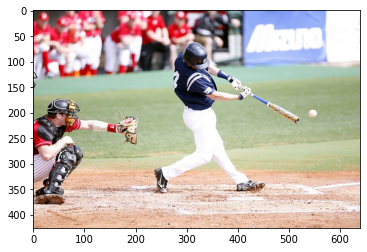

In [44]:
test_image = '/content/pytorch_advanced/4_pose_estimation/data/hit-1407826_640.jpg'
oriImg = cv2.imread(test_image)  # B,G,Rの順番

# BGRをRGBにして表示
oriImg = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
plt.imshow(oriImg)
plt.show()

# 画像のリサイズ
size = (368, 368)
img = cv2.resize(oriImg, size, interpolation=cv2.INTER_CUBIC)

# 画像の前処理
img = img.astype(np.float32) / 255.

# 色情報の標準化
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]

# 21/03/07 Issue147 https://github.com/YutaroOgawa/pytorch_advanced/issues/147
# 色チャネルの順番を誤っています
# preprocessed_img = img.copy()[:, :, ::-1]  # RGB→BGR
preprocessed_img = img.copy()  # RGB

for i in range(3):
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - color_mean[i]
    preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / color_std[i]

# （高さ、幅、色）→（色、高さ、幅）
img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32)

# 画像をTensorに
img = torch.from_numpy(img)

# ミニバッチ化：torch.Size([1, 3, 368, 368])
x = img.unsqueeze(0)

In [45]:
# OpenPoseでheatmapsとPAFsを求めます
net.eval()
predicted_outputs, _ = net(x)

# 画像をテンソルからNumPyに変化し、サイズを戻します
pafs = predicted_outputs[0][0].detach().numpy().transpose(1, 2, 0)
heatmaps = predicted_outputs[1][0].detach().numpy().transpose(1, 2, 0)

pafs = cv2.resize(pafs, size, interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation=cv2.INTER_CUBIC)

pafs = cv2.resize(
    pafs, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(
    heatmaps, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

In [46]:
import math

import cv2
import matplotlib.cm
import numpy as np
from scipy.ndimage.filters import gaussian_filter, maximum_filter
from scipy.ndimage.morphology import generate_binary_structure

# It is better to use 0.1 as threshold when evaluation, but 0.3 for demo
# purpose.
cmap = matplotlib.cm.get_cmap('hsv')

# Heatmap indices to find each limb (joint connection). Eg: limb_type=1 is
# Neck->LShoulder, so joint_to_limb_heatmap_relationship[1] represents the
# indices of heatmaps to look for joints: neck=1, LShoulder=5
joint_to_limb_heatmap_relationship = [
    [1, 2], [1, 5], [2, 3], [3, 4], [5, 6], [6, 7], [1, 8], [8, 9], [9, 10],
    [1, 11], [11, 12], [12, 13], [1, 0], [0, 14], [14, 16], [0, 15], [15, 17],
    [2, 16], [5, 17]]

# PAF indices containing the x and y coordinates of the PAF for a given limb.
# Eg: limb_type=1 is Neck->LShoulder, so
# PAFneckLShoulder_x=paf_xy_coords_per_limb[1][0] and
# PAFneckLShoulder_y=paf_xy_coords_per_limb[1][1]
paf_xy_coords_per_limb = [
    [12, 13], [20, 21], [14, 15], [16, 17], [22, 23],
    [24, 25], [0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [28, 29],
    [30, 31], [34, 35], [32, 33], [36, 37], [18, 19], [26, 27]]

# Color code used to plot different joints and limbs (eg: joint_type=3 and
# limb_type=3 will use colors[3])
colors = [
    [255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0],
    [85, 255, 0], [0, 255, 0], [0, 255, 85], [0, 255, 170], [0, 255, 255],
    [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], [170, 0, 255],
    [255, 0, 255], [255, 0, 170], [255, 0, 85], [255, 0, 0]]

NUM_JOINTS = 18
NUM_LIMBS = len(joint_to_limb_heatmap_relationship)


def find_peaks(param, img):
    """
    Given a (grayscale) image, find local maxima whose value is above a given
    threshold (param['thre1'])
    :param img: Input image (2d array) where we want to find peaks
    :return: 2d np.array containing the [x,y] coordinates of each peak found
    in the image
    """

    peaks_binary = (maximum_filter(img, footprint=generate_binary_structure(
        2, 1)) == img) * (img > param['thre1'])
    # Note reverse ([::-1]): we return [[x y], [x y]...] instead of [[y x], [y
    # x]...]
    return np.array(np.nonzero(peaks_binary)[::-1]).T


def compute_resized_coords(coords, resizeFactor):
    """
    Given the index/coordinates of a cell in some input array (e.g. image),
    provides the new coordinates if that array was resized by making it
    resizeFactor times bigger.
    E.g.: image of size 3x3 is resized to 6x6 (resizeFactor=2), we'd like to
    know the new coordinates of cell [1,2] -> Function would return [2.5,4.5]
    :param coords: Coordinates (indices) of a cell in some input array
    :param resizeFactor: Resize coefficient = shape_dest/shape_source. E.g.:
    resizeFactor=2 means the destination array is twice as big as the
    original one
    :return: Coordinates in an array of size
    shape_dest=resizeFactor*shape_source, expressing the array indices of the
    closest point to 'coords' if an image of size shape_source was resized to
    shape_dest
    """

    # 1) Add 0.5 to coords to get coordinates of center of the pixel (e.g.
    # index [0,0] represents the pixel at location [0.5,0.5])
    # 2) Transform those coordinates to shape_dest, by multiplying by resizeFactor
    # 3) That number represents the location of the pixel center in the new array,
    # so subtract 0.5 to get coordinates of the array index/indices (revert
    # step 1)
    return (np.array(coords, dtype=float) + 0.5) * resizeFactor - 0.5


def NMS(param, heatmaps, upsampFactor=1., bool_refine_center=True, bool_gaussian_filt=False):
    """
    NonMaximaSuppression: find peaks (local maxima) in a set of grayscale images
    :param heatmaps: set of grayscale images on which to find local maxima (3d np.array,
    with dimensions image_height x image_width x num_heatmaps)
    :param upsampFactor: Size ratio between CPM heatmap output and the input image size.
    Eg: upsampFactor=16 if original image was 480x640 and heatmaps are 30x40xN
    :param bool_refine_center: Flag indicating whether:
     - False: Simply return the low-res peak found upscaled by upsampFactor (subject to grid-snap)
     - True: (Recommended, very accurate) Upsample a small patch around each low-res peak and
     fine-tune the location of the peak at the resolution of the original input image
    :param bool_gaussian_filt: Flag indicating whether to apply a 1d-GaussianFilter (smoothing)
    to each upsampled patch before fine-tuning the location of each peak.
    :return: a NUM_JOINTS x 4 np.array where each row represents a joint type (0=nose, 1=neck...)
    and the columns indicate the {x,y} position, the score (probability) and a unique id (counter)
    """
    # MODIFIED BY CARLOS: Instead of upsampling the heatmaps to heatmap_avg and
    # then performing NMS to find peaks, this step can be sped up by ~25-50x by:
    # (9-10ms [with GaussFilt] or 5-6ms [without GaussFilt] vs 250-280ms on RoG
    # 1. Perform NMS at (low-res) CPM's output resolution
    # 1.1. Find peaks using scipy.ndimage.filters.maximum_filter
    # 2. Once a peak is found, take a patch of 5x5 centered around the peak, upsample it, and
    # fine-tune the position of the actual maximum.
    #  '-> That's equivalent to having found the peak on heatmap_avg, but much faster because we only
    #      upsample and scan the 5x5 patch instead of the full (e.g.) 480x640

    joint_list_per_joint_type = []
    cnt_total_joints = 0

    # For every peak found, win_size specifies how many pixels in each
    # direction from the peak we take to obtain the patch that will be
    # upsampled. Eg: win_size=1 -> patch is 3x3; win_size=2 -> 5x5
    # (for BICUBIC interpolation to be accurate, win_size needs to be >=2!)
    win_size = 2

    for joint in range(NUM_JOINTS):
        map_orig = heatmaps[:, :, joint]
        peak_coords = find_peaks(param, map_orig)
        peaks = np.zeros((len(peak_coords), 4))
        for i, peak in enumerate(peak_coords):
            if bool_refine_center:
                x_min, y_min = np.maximum(0, peak - win_size)
                x_max, y_max = np.minimum(
                    np.array(map_orig.T.shape) - 1, peak + win_size)

                # Take a small patch around each peak and only upsample that
                # tiny region
                patch = map_orig[y_min:y_max + 1, x_min:x_max + 1]
                map_upsamp = cv2.resize(
                    patch, None, fx=upsampFactor, fy=upsampFactor, interpolation=cv2.INTER_CUBIC)

                # Gaussian filtering takes an average of 0.8ms/peak (and there might be
                # more than one peak per joint!) -> For now, skip it (it's
                # accurate enough)
                map_upsamp = gaussian_filter(
                    map_upsamp, sigma=3) if bool_gaussian_filt else map_upsamp

                # Obtain the coordinates of the maximum value in the patch
                location_of_max = np.unravel_index(
                    map_upsamp.argmax(), map_upsamp.shape)
                # Remember that peaks indicates [x,y] -> need to reverse it for
                # [y,x]
                location_of_patch_center = compute_resized_coords(
                    peak[::-1] - [y_min, x_min], upsampFactor)
                # Calculate the offset wrt to the patch center where the actual
                # maximum is
                refined_center = (location_of_max - location_of_patch_center)
                peak_score = map_upsamp[location_of_max]
            else:
                refined_center = [0, 0]
                # Flip peak coordinates since they are [x,y] instead of [y,x]
                peak_score = map_orig[tuple(peak[::-1])]
            peaks[i, :] = tuple([int(round(x)) for x in compute_resized_coords(
                peak_coords[i], upsampFactor) + refined_center[::-1]]) + (peak_score, cnt_total_joints)
            cnt_total_joints += 1
        joint_list_per_joint_type.append(peaks)

    return joint_list_per_joint_type


def find_connected_joints(param, paf_upsamp, joint_list_per_joint_type, num_intermed_pts=10):
    """
    For every type of limb (eg: forearm, shin, etc.), look for every potential
    pair of joints (eg: every wrist-elbow combination) and evaluate the PAFs to
    determine which pairs are indeed body limbs.
    :param paf_upsamp: PAFs upsampled to the original input image resolution
    :param joint_list_per_joint_type: See 'return' doc of NMS()
    :param num_intermed_pts: Int indicating how many intermediate points to take
    between joint_src and joint_dst, at which the PAFs will be evaluated
    :return: List of NUM_LIMBS rows. For every limb_type (a row) we store
    a list of all limbs of that type found (eg: all the right forearms).
    For each limb (each item in connected_limbs[limb_type]), we store 5 cells:
    # {joint_src_id,joint_dst_id}: a unique number associated with each joint,
    # limb_score_penalizing_long_dist: a score of how good a connection
    of the joints is, penalized if the limb length is too long
    # {joint_src_index,joint_dst_index}: the index of the joint within
    all the joints of that type found (eg: the 3rd right elbow found)
    """
    connected_limbs = []

    # Auxiliary array to access paf_upsamp quickly
    limb_intermed_coords = np.empty((4, num_intermed_pts), dtype=np.intp)
    for limb_type in range(NUM_LIMBS):
        # List of all joints of type A found, where A is specified by limb_type
        # (eg: a right forearm starts in a right elbow)
        joints_src = joint_list_per_joint_type[joint_to_limb_heatmap_relationship[limb_type][0]]
        # List of all joints of type B found, where B is specified by limb_type
        # (eg: a right forearm ends in a right wrist)
        joints_dst = joint_list_per_joint_type[joint_to_limb_heatmap_relationship[limb_type][1]]
        if len(joints_src) == 0 or len(joints_dst) == 0:
            # No limbs of this type found (eg: no right forearms found because
            # we didn't find any right wrists or right elbows)
            connected_limbs.append([])
        else:
            connection_candidates = []
            # Specify the paf index that contains the x-coord of the paf for
            # this limb
            limb_intermed_coords[2, :] = paf_xy_coords_per_limb[limb_type][0]
            # And the y-coord paf index
            limb_intermed_coords[3, :] = paf_xy_coords_per_limb[limb_type][1]
            for i, joint_src in enumerate(joints_src):
                # Try every possible joints_src[i]-joints_dst[j] pair and see
                # if it's a feasible limb
                for j, joint_dst in enumerate(joints_dst):
                    # Subtract the position of both joints to obtain the
                    # direction of the potential limb
                    limb_dir = joint_dst[:2] - joint_src[:2]
                    # Compute the distance/length of the potential limb (norm
                    # of limb_dir)
                    limb_dist = np.sqrt(np.sum(limb_dir**2)) + 1e-8
                    limb_dir = limb_dir / limb_dist  # Normalize limb_dir to be a unit vector

                    # Linearly distribute num_intermed_pts points from the x
                    # coordinate of joint_src to the x coordinate of joint_dst
                    limb_intermed_coords[1, :] = np.round(np.linspace(
                        joint_src[0], joint_dst[0], num=num_intermed_pts))
                    limb_intermed_coords[0, :] = np.round(np.linspace(
                        joint_src[1], joint_dst[1], num=num_intermed_pts))  # Same for the y coordinate
                    intermed_paf = paf_upsamp[limb_intermed_coords[0, :],
                                              limb_intermed_coords[1, :], limb_intermed_coords[2:4, :]].T

                    score_intermed_pts = intermed_paf.dot(limb_dir)
                    score_penalizing_long_dist = score_intermed_pts.mean(
                    ) + min(0.5 * paf_upsamp.shape[0] / limb_dist - 1, 0)
                    # Criterion 1: At least 80% of the intermediate points have
                    # a score higher than thre2
                    criterion1 = (np.count_nonzero(
                        score_intermed_pts > param['thre2']) > 0.8 * num_intermed_pts)
                    # Criterion 2: Mean score, penalized for large limb
                    # distances (larger than half the image height), is
                    # positive
                    criterion2 = (score_penalizing_long_dist > 0)
                    if criterion1 and criterion2:
                        # Last value is the combined paf(+limb_dist) + heatmap
                        # scores of both joints
                        connection_candidates.append(
                            [i, j, score_penalizing_long_dist, score_penalizing_long_dist + joint_src[2] + joint_dst[2]])

            # Sort connection candidates based on their
            # score_penalizing_long_dist
            connection_candidates = sorted(
                connection_candidates, key=lambda x: x[2], reverse=True)
            connections = np.empty((0, 5))
            # There can only be as many limbs as the smallest number of source
            # or destination joints (eg: only 2 forearms if there's 5 wrists
            # but 2 elbows)
            max_connections = min(len(joints_src), len(joints_dst))
            # Traverse all potential joint connections (sorted by their score)
            for potential_connection in connection_candidates:
                i, j, s = potential_connection[0:3]
                # Make sure joints_src[i] or joints_dst[j] haven't already been
                # connected to other joints_dst or joints_src
                if i not in connections[:, 3] and j not in connections[:, 4]:
                    # [joint_src_id, joint_dst_id, limb_score_penalizing_long_dist, joint_src_index, joint_dst_index]
                    connections = np.vstack(
                        [connections, [joints_src[i][3], joints_dst[j][3], s, i, j]])
                    # Exit if we've already established max_connections
                    # connections (each joint can't be connected to more than
                    # one joint)
                    if len(connections) >= max_connections:
                        break
            connected_limbs.append(connections)

    return connected_limbs


def group_limbs_of_same_person(connected_limbs, joint_list):
    """
    Associate limbs belonging to the same person together.
    :param connected_limbs: See 'return' doc of find_connected_joints()
    :param joint_list: unravel'd version of joint_list_per_joint [See 'return' doc of NMS()]
    :return: 2d np.array of size num_people x (NUM_JOINTS+2). For each person found:
    # First NUM_JOINTS columns contain the index (in joint_list) of the joints associated
    with that person (or -1 if their i-th joint wasn't found)
    # 2nd-to-last column: Overall score of the joints+limbs that belong to this person
    # Last column: Total count of joints found for this person
    """
    person_to_joint_assoc = []

    for limb_type in range(NUM_LIMBS):
        joint_src_type, joint_dst_type = joint_to_limb_heatmap_relationship[limb_type]

        for limb_info in connected_limbs[limb_type]:
            person_assoc_idx = []
            for person, person_limbs in enumerate(person_to_joint_assoc):
                if person_limbs[joint_src_type] == limb_info[0] or person_limbs[joint_dst_type] == limb_info[1]:
                    person_assoc_idx.append(person)

            # If one of the joints has been associated to a person, and either
            # the other joint is also associated with the same person or not
            # associated to anyone yet:
            if len(person_assoc_idx) == 1:
                person_limbs = person_to_joint_assoc[person_assoc_idx[0]]
                # If the other joint is not associated to anyone yet,
                if person_limbs[joint_dst_type] != limb_info[1]:
                    # Associate it with the current person
                    person_limbs[joint_dst_type] = limb_info[1]
                    # Increase the number of limbs associated to this person
                    person_limbs[-1] += 1
                    # And update the total score (+= heatmap score of joint_dst
                    # + score of connecting joint_src with joint_dst)
                    person_limbs[-2] += joint_list[limb_info[1]
                                                   .astype(int), 2] + limb_info[2]
            elif len(person_assoc_idx) == 2:  # if found 2 and disjoint, merge them
                person1_limbs = person_to_joint_assoc[person_assoc_idx[0]]
                person2_limbs = person_to_joint_assoc[person_assoc_idx[1]]
                membership = ((person1_limbs >= 0) & (person2_limbs >= 0))[:-2]
                if not membership.any():  # If both people have no same joints connected, merge them into a single person
                    # Update which joints are connected
                    person1_limbs[:-2] += (person2_limbs[:-2] + 1)
                    # Update the overall score and total count of joints
                    # connected by summing their counters
                    person1_limbs[-2:] += person2_limbs[-2:]
                    # Add the score of the current joint connection to the
                    # overall score
                    person1_limbs[-2] += limb_info[2]
                    person_to_joint_assoc.pop(person_assoc_idx[1])
                else:  # Same case as len(person_assoc_idx)==1 above
                    person1_limbs[joint_dst_type] = limb_info[1]
                    person1_limbs[-1] += 1
                    person1_limbs[-2] += joint_list[limb_info[1]
                                                    .astype(int), 2] + limb_info[2]
            else:  # No person has claimed any of these joints, create a new person
                # Initialize person info to all -1 (no joint associations)
                row = -1 * np.ones(20)
                # Store the joint info of the new connection
                row[joint_src_type] = limb_info[0]
                row[joint_dst_type] = limb_info[1]
                # Total count of connected joints for this person: 2
                row[-1] = 2
                # Compute overall score: score joint_src + score joint_dst + score connection
                # {joint_src,joint_dst}
                row[-2] = sum(joint_list[limb_info[:2].astype(int), 2]
                              ) + limb_info[2]
                person_to_joint_assoc.append(row)

    # Delete people who have very few parts connected
    people_to_delete = []
    for person_id, person_info in enumerate(person_to_joint_assoc):
        if person_info[-1] < 3 or person_info[-2] / person_info[-1] < 0.2:
            people_to_delete.append(person_id)
    # Traverse the list in reverse order so we delete indices starting from the
    # last one (otherwise, removing item for example 0 would modify the indices of
    # the remaining people to be deleted!)
    for index in people_to_delete[::-1]:
        person_to_joint_assoc.pop(index)

    # Appending items to a np.array can be very costly (allocating new memory, copying over the array, then adding new row)
    # Instead, we treat the set of people as a list (fast to append items) and
    # only convert to np.array at the end
    return np.array(person_to_joint_assoc)


def plot_pose(img_orig, joint_list, person_to_joint_assoc, bool_fast_plot=True, plot_ear_to_shoulder=False):
    canvas = img_orig.copy()  # Make a copy so we don't modify the original image

    # to_plot is the location of all joints found overlaid on top of the
    # original image
    to_plot = canvas.copy() if bool_fast_plot else cv2.addWeighted(
        img_orig, 0.3, canvas, 0.7, 0)

    limb_thickness = 4
    # Last 2 limbs connect ears with shoulders and this looks very weird.
    # Disabled by default to be consistent with original rtpose output
    which_limbs_to_plot = NUM_LIMBS if plot_ear_to_shoulder else NUM_LIMBS - 2
    for limb_type in range(which_limbs_to_plot):
        for person_joint_info in person_to_joint_assoc:
            joint_indices = person_joint_info[joint_to_limb_heatmap_relationship[limb_type]].astype(
                int)
            if -1 in joint_indices:
                # Only draw actual limbs (connected joints), skip if not
                # connected
                continue
            # joint_coords[:,0] represents Y coords of both joints;
            # joint_coords[:,1], X coords
            joint_coords = joint_list[joint_indices, 0:2]

            for joint in joint_coords:  # Draw circles at every joint
                cv2.circle(canvas, tuple(joint[0:2].astype(
                    int)), 4, (255, 255, 255), thickness=-1)
            # mean along the axis=0 computes meanYcoord and meanXcoord -> Round
            # and make int to avoid errors
            coords_center = tuple(
                np.round(np.mean(joint_coords, 0)).astype(int))
            # joint_coords[0,:] is the coords of joint_src; joint_coords[1,:]
            # is the coords of joint_dst
            limb_dir = joint_coords[0, :] - joint_coords[1, :]
            limb_length = np.linalg.norm(limb_dir)
            # Get the angle of limb_dir in degrees using atan2(limb_dir_x,
            # limb_dir_y)
            angle = math.degrees(math.atan2(limb_dir[1], limb_dir[0]))

            # For faster plotting, just plot over canvas instead of constantly
            # copying it
            cur_canvas = canvas if bool_fast_plot else canvas.copy()
            polygon = cv2.ellipse2Poly(
                coords_center, (int(limb_length / 2), limb_thickness), int(angle), 0, 360, 1)
            cv2.fillConvexPoly(cur_canvas, polygon, colors[limb_type])
            if not bool_fast_plot:
                canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)

    return to_plot, canvas


def decode_pose(img_orig, heatmaps, pafs):
    param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}

    # Bottom-up approach:
    # Step 1: find all joints in the image (organized by joint type: [0]=nose,
    # [1]=neck...)
    joint_list_per_joint_type = NMS(param,
                                    heatmaps, img_orig.shape[0] / float(heatmaps.shape[0]))
    # joint_list is an unravel'd version of joint_list_per_joint, where we add
    # a 5th column to indicate the joint_type (0=nose, 1=neck...)
    joint_list = np.array([tuple(peak) + (joint_type,) for joint_type,
                           joint_peaks in enumerate(joint_list_per_joint_type) for peak in joint_peaks])

    # Step 2: find which joints go together to form limbs (which wrists go
    # with which elbows)
    paf_upsamp = cv2.resize(
        pafs, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_CUBIC)
    connected_limbs = find_connected_joints(param,
                                            paf_upsamp, joint_list_per_joint_type)

    # Step 3: associate limbs that belong to the same person
    person_to_joint_assoc = group_limbs_of_same_person(
        connected_limbs, joint_list)

    # (Step 4): plot results
    to_plot, canvas = plot_pose(img_orig, joint_list, person_to_joint_assoc)

    return to_plot, canvas, joint_list, person_to_joint_assoc

In [47]:
_, result_img, _, _ = decode_pose(oriImg, heatmaps, pafs)

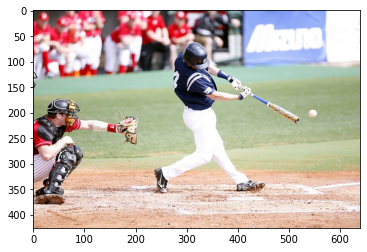

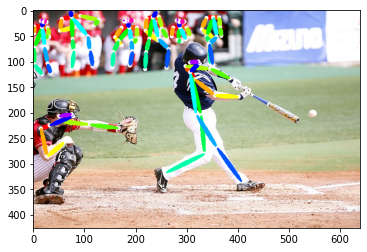

In [48]:
plt.imshow(oriImg)
plt.show()

plt.imshow(result_img)
plt.show()